# Exploratory Analysis

chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://ec.europa.eu/eurostat/documents/3433488/5579176/KS-SF-11-034-EN.PDF/63cebff3-f7ac-4ca6-ab33-4e8792c5f30c

https://appsso.eurostat.ec.europa.eu/nui/submitViewTableAction.do

https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_by_immigrant_population

https://data.worldbank.org/indicator/SM.POP.TOTL.ZS?name_desc=false&view=map

https://en.wikipedia.org/wiki/Demographics_of_Europe

https://data.oecd.org/migration/foreign-population.htm

https://www.weforum.org/agenda/2019/03/which-countries-have-the-most-immigrants-51048ff1f9/

In [1]:
import pandas as pd
import numpy as np
import requests 
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib

import folium # map rendering library

% matplotlib inline

## Read and Process Restaurant Data

In [2]:
city_list = ['Dublin','Zurich','Warsaw','Vienna','Riga','Prague','Podgorica','Athens',
             'Porto','Barcelona','Milan','Copenhagen','Reykjavik','Lyon','Munich',
             'Luxembourg','Oslo','Vaduz','Sofia','Amsterdam','Bucharest','London']

' Read in data files into single dataframe '
df_restaurants = pd.DataFrame()
for city in city_list:
    
    ' Read in city file '
    file_location = './Data/{}/{}_restaurants.csv'.format(city, city.lower())
    df_city = pd.read_csv(file_location,encoding='utf-8')
    
    ' Append City Name to dataframe '
    df_city['city'] = city
    df_city = df_city[['city','lat_centre','long_centre','num_venues','venue_iter','venue_id','venue_name','lat_venue','long_venue','category']]
    
    'Append results to master dataframe '
    df_restaurants = df_restaurants.append(df_city, ignore_index=True)
    
' Extract Cuisine Type from Category column '
df_restaurants['cuisine'] = df_restaurants['category'].apply(lambda x:x.replace(' Restaurant','').lower())


In [3]:
df_restaurants['city'].value_counts()

London        6588
Barcelona     3236
Warsaw        1758
Milan         1598
Vienna        1475
Munich        1468
Prague        1331
Athens        1265
Amsterdam     1062
Zurich        1007
Bucharest     1001
Copenhagen     961
Porto          894
Sofia          868
Lyon           737
Riga           680
Dublin         628
Oslo           432
Luxembourg     216
Reykjavik       90
Podgorica       79
Vaduz           48
Name: city, dtype: int64

## Construct dataframe with frequency of cuisine types in each City

In [4]:
' Create empty dataframe '
df_cuisine_count = pd.DataFrame()

for city in city_list:
    
    ' Obtain cuisine counts in city '
    df_count = df_restaurants[ df_restaurants['city'] == city ]['cuisine'].value_counts().to_frame()
    df_count.columns = [ city.lower() ]
    
    ' Join to master dataframe '
    df_cuisine_count = df_cuisine_count.join(df_count, how='outer')
    
' Replace empty values with zero '
df_cuisine_count.fillna(0, inplace=True)

In [5]:
df_cuisine_count.head(3)

,dublin,zurich,warsaw,vienna,riga,prague,podgorica,athens,porto,barcelona,...,reykjavik,lyon,munich,luxembourg,oslo,vaduz,sofia,amsterdam,bucharest,london
abruzzo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
afghan,1.0,1.0,17.0,4.0,36.0,8.0,0.0,1.0,2.0,0.0,...,2.0,1.0,6.0,1.0,1.0,0.0,4.0,2.0,4.0,14.0
african,5.0,3.0,16.0,5.0,27.0,3.0,1.0,1.0,8.0,7.0,...,2.0,6.0,6.0,0.0,4.0,0.0,3.0,7.0,3.0,131.0


## Read and Process Demographic Data

In [6]:
country_list = ['Ireland','Switzerland','Poland','Austria','Latvia','Czechia','Montenegro',
                'Greece','Portugal','Spain','Italy','Denmark','Iceland','France','Germany',
                'Luxembourg','Norway','Liechtenstein','Bulgaria','Netherlands','Romania','UK']


def get_citizenship_filename(country):
    
    if country == 'France':
        filename = 'France_2017.csv'
    elif country == 'Montenegro':
        filename = 'Montenegro_2011.csv'
    else:
        filename = '{}_2019.csv'.format(country)
    
    return('./Data/Citizenship/{}'.format(filename))
    
    
' Read and process population data ' 
df_demo = pd.DataFrame()
for country in country_list:
    
    file_location = get_citizenship_filename(country)
    df_country = pd.read_csv(file_location)
    
    ' Transform dataframe '
    df_country = df_country[ df_country['SEX']=='Total' ]
    df_country = df_country[['GEO','CITIZEN','Value']]
    df_country.rename(columns={"GEO": "country", "CITIZEN": "citizenship","Value":"count"}, inplace=True)
    df_country.drop(df_country.index[df_country['citizenship'] == 'Total'], inplace = True)
    df_country['count'] = df_country['count'].str.replace(",", "").replace(":", "0")
    df_country['count'] = df_country['count'].astype('int32')
    country_name = df_country['country'].unique()[0].split()[0].lower()
    df_country.drop('country', axis=1, inplace=True)
    df_country.set_index('citizenship', inplace=True)
    df_country.columns = [country_name]
    
    ' Join to master dataframe '
    df_demo = df_country.join(df_demo)
    
' Rename United Kingdom -> UK '
df_demo.rename(columns={'united':'uk'},inplace=True)


In [7]:
df_demo.sum()

uk               66647112
romania          19413965
netherlands      17225855
bulgaria          6989979
liechtenstein       38378
norway            5325403
luxembourg         613501
germany          82819865
france           66809816
iceland            356942
denmark           5797728
italy            60358697
spain            46692528
portugal         10276529
greece           10106077
montenegro         598321
czechia          10647546
latvia            1714005
austria           8842534
poland           37714705
switzerland       8430342
ireland           4901396
dtype: int64

In [8]:
df_demo.head(3)

,uk,romania,netherlands,bulgaria,liechtenstein,norway,luxembourg,germany,france,iceland,...,spain,portugal,greece,montenegro,czechia,latvia,austria,poland,switzerland,ireland
citizenship,,,,,,,,,,,,,,,,,,,,,
Belgium,23135,985,34447,209,25,1284,19953,25904,102066,104,...,36980,4147,1279,1,809,37,2575,660,13474,1674
Bulgaria,102345,2814,31208,6896086,11,7349,1726,319271,23188,414,...,123335,6931,81174,32,15632,115,29920,2327,10054,2592
Czechia,46573,543,4144,416,22,1898,1130,56259,4628,692,...,0,463,913,23,10092342,34,13590,1123,8407,5302


## Clustering 

What cities offer a similar selection of cuisines? And what countries possess similar demographics in their migrant populations? 

These are the questions we will address here. 

## Clustering on Cuisines

Are the cuisines available in restaurants across European cities more or less the same? Or are there distinct types? We shall explore this topic here. 

We begin by creating the cuisine feature vectors for each city. The hard work has previously being done!

In [9]:
df_cuisine_vectors = df_cuisine_count.transpose()
df_cuisine_vectors.head(3)

,abruzzo,afghan,african,american,arepa,argentinian,asian,australian,austrian,bangladeshi,...,turkish home cooking,udon,ukrainian,umbrian,vegetarian / vegan,veneto,venezuelan,vietnamese,xinjiang,yemeni
dublin,0.0,1.0,5.0,11.0,2.0,3.0,72.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0
zurich,0.0,1.0,3.0,9.0,2.0,7.0,71.0,1.0,5.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0
warsaw,0.0,17.0,16.0,44.0,6.0,3.0,203.0,2.0,1.0,0.0,...,0.0,1.0,5.0,0.0,4.0,0.0,0.0,76.0,0.0,0.0


We have 130 different cuisine types in our feature vectors. Let us normalize these vectors (so that the cuisine vectors all have unit length) and perform k-means clustering. 

We shall use the elbow method to determine the optimal number of clusters.

In [11]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

X = df_cuisine_vectors

# Normaize features
X = normalize(X)

#kmeans = KMeans(n_clusters=3, random_state=0)
#model = kmeans.fit(X)
#model.cluster_centers_.shape

Text(0.5,1,'The Elbow Method using Inertia')

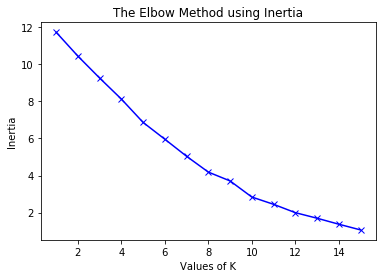

In [15]:
inertias = [] 
K = range(1,16) 
  
for k in K: 
    
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    inertias.append(kmeanModel.inertia_) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 

In [17]:
df_cuisine_vectors.index

Index([u'dublin', u'zurich', u'warsaw', u'vienna', u'riga', u'prague',
       u'podgorica', u'athens', u'porto', u'barcelona', u'milan',
       u'copenhagen', u'reykjavik', u'lyon', u'munich', u'luxembourg', u'oslo',
       u'vaduz', u'sofia', u'amsterdam', u'bucharest', u'london'],
      dtype='object')

## Cosine Distance

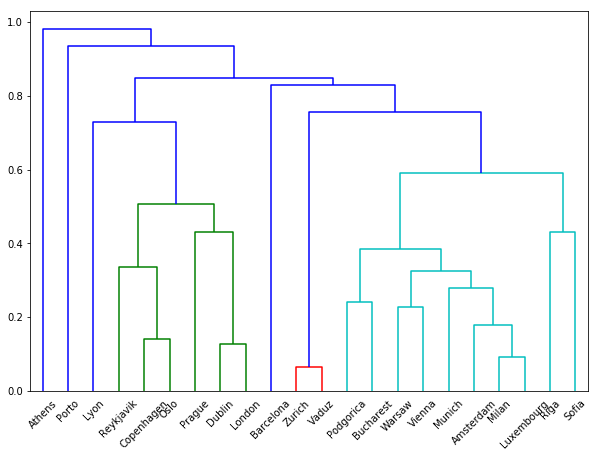

In [100]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

X = df_cuisine_vectors

# generate the linkage matrix
# method = single (min), complete (max), average, centroid, median, ward
# metric: ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#         ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, 
#         ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, 
#         ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’
linked = linkage(X, method='complete', metric='cosine')

labelList = range(len(X))

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=city_list,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [55]:
from sklearn.cluster import AgglomerativeClustering 

num_clusters = 7
hc = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'cosine', linkage ='complete')
hc.fit(X)
labels = hc.labels_

In [20]:
labels

array([1, 2, 0, 0, 0, 1, 0, 3, 5, 4, 0, 1, 1, 6, 0, 0, 1, 2, 0, 0, 0, 1])

In [56]:
for j in range(num_clusters):
    
    bool_list = (labels==j)

    cities = []
    for i in range(len(labels)):
        if bool_list[i] == True:
            cities.append(city_list[i])
        
    print(cities)

['Warsaw', 'Vienna', 'Riga', 'Podgorica', 'Milan', 'Munich', 'Luxembourg', 'Sofia', 'Amsterdam', 'Bucharest']
['Dublin', 'Prague', 'Copenhagen', 'Reykjavik', 'Oslo', 'London']
['Zurich', 'Vaduz']
['Athens']
['Barcelona']
['Porto']
['Lyon']


## Keep only top N cuisine types

In [125]:
N = 8

df_cuisine_vectors_trunc = df_cuisine_vectors.copy()

for city in df_cuisine_vectors_trunc.index:

    cutoff_value = df_cuisine_vectors_trunc.loc[city,:].sort_values(ascending=False)[0:N][-1]
    
    bool_series = df_cuisine_vectors_trunc.loc[city,:] < cutoff_value
    
    df_cuisine_vectors_trunc.loc[city,bool_series] = 0
    
    print city + ": " + str(sum( df_cuisine_vectors_trunc.loc[city,:] > 0 ))

dublin: 8
zurich: 9
warsaw: 8
vienna: 8
riga: 8
prague: 8
podgorica: 10
athens: 8
porto: 8
barcelona: 8
milan: 8
copenhagen: 8
reykjavik: 8
lyon: 8
munich: 8
luxembourg: 8
oslo: 8
vaduz: 8
sofia: 8
amsterdam: 8
bucharest: 8
london: 8


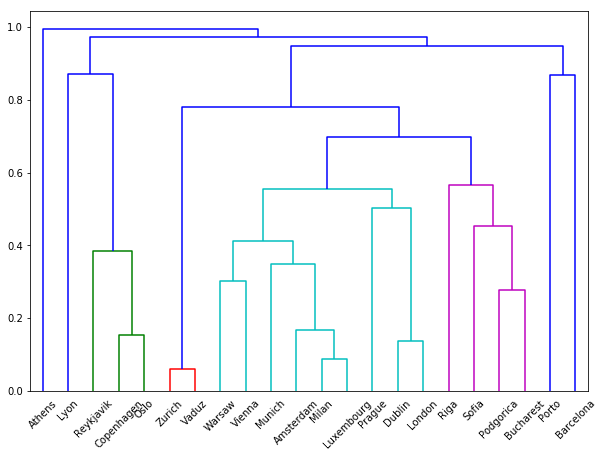

In [126]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

X = df_cuisine_vectors_trunc

# generate the linkage matrix
# method = single (min), complete (max), average, centroid, median, ward
# metric: ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#         ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, 
#         ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, 
#         ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’
linked = linkage(X, method='complete', metric='cosine')

labelList = range(len(X))

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=city_list,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [24]:
from sklearn.cluster import AgglomerativeClustering 

num_clusters = 7
hc = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'cosine', linkage ='complete')
hc.fit(X)
labels = hc.labels_

In [25]:
labels

array([0, 6, 0, 0, 0, 0, 0, 3, 5, 4, 0, 2, 2, 1, 0, 0, 2, 6, 0, 0, 0, 0])

In [26]:
for j in range(num_clusters):
    
    bool_list = (labels==j)

    cities = []
    for i in range(len(labels)):
        if bool_list[i] == True:
            cities.append(city_list[i])
        
    print(cities)

['Dublin', 'Warsaw', 'Vienna', 'Riga', 'Prague', 'Podgorica', 'Milan', 'Munich', 'Luxembourg', 'Sofia', 'Amsterdam', 'Bucharest', 'London']
['Lyon']
['Copenhagen', 'Reykjavik', 'Oslo']
['Athens']
['Barcelona']
['Porto']
['Zurich', 'Vaduz']


## Binary Clustering: Poor - Group by City Size!

In [123]:
df_cuisine_binary_vectors = df_cuisine_vectors.copy()

df_cuisine_binary_vectors = df_cuisine_binary_vectors>0

for column in df_cuisine_binary_vectors.columns:
    df_cuisine_binary_vectors[column] = df_cuisine_binary_vectors[column].astype('int')

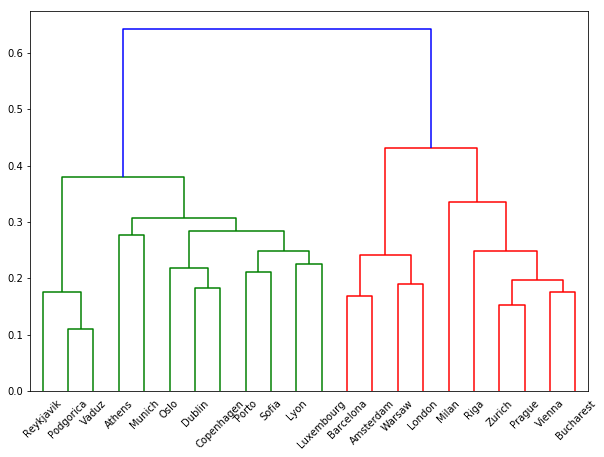

In [124]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

X = df_cuisine_binary_vectors

# generate the linkage matrix
# method = single (min), complete (max), average, centroid, median, ward
# metric: ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#         ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, 
#         ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, 
#         ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’
linked = linkage(X, method='complete', metric='hamming')

labelList = range(len(X))

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=city_list,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [58]:
from sklearn.cluster import AgglomerativeClustering 

num_clusters = 2
hc = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'hamming', linkage ='complete')
#num_clusters=3
#hc = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'euclidean', linkage ='ward')
hc.fit(X)
labels = hc.labels_

In [59]:
labels

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [60]:
for j in range(num_clusters):
    
    bool_list = (labels==j)

    cities = []
    for i in range(len(labels)):
        if bool_list[i] == True:
            cities.append(city_list[i])
        
    print(cities)

['Zurich', 'Warsaw', 'Vienna', 'Riga', 'Prague', 'Barcelona', 'Milan', 'Amsterdam', 'Bucharest', 'London']
['Dublin', 'Podgorica', 'Athens', 'Porto', 'Copenhagen', 'Reykjavik', 'Lyon', 'Munich', 'Luxembourg', 'Oslo', 'Vaduz', 'Sofia']


## Method of Moments

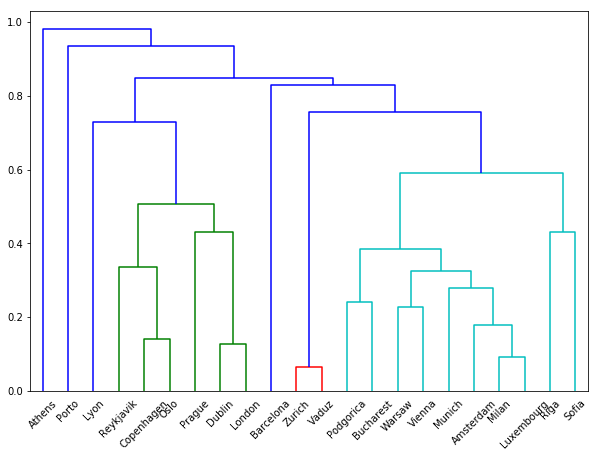

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

q = 1

X = df_cuisine_vectors

# Normaize features
X = normalize(X)

X = X**q

X = normalize(X)

# generate the linkage matrix
# method = single (min), complete (max), average, centroid, median, ward
# metric: ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#         ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, 
#         ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, 
#         ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’
linked = linkage(X, method='complete', metric='cosine')

labelList = range(len(X))

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=city_list,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

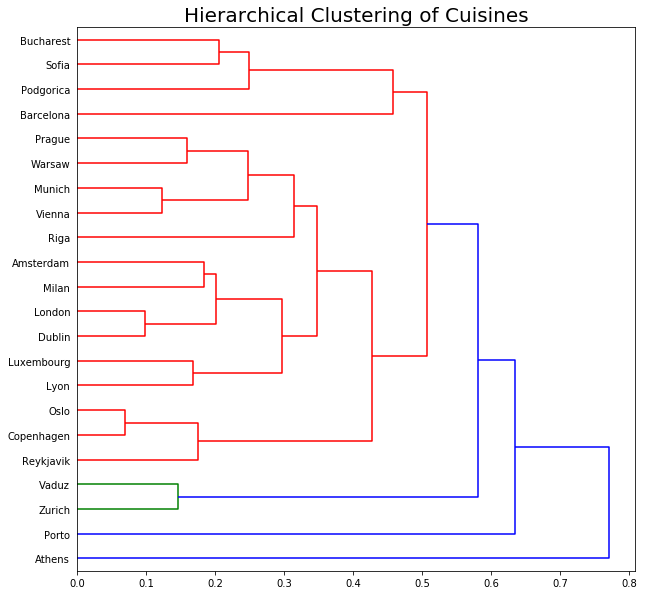

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

q = 0.5

X = df_cuisine_vectors

# Normaize features
X = normalize(X)

X = X**q

X = normalize(X)

# generate the linkage matrix
# method = single (min), complete (max), average, centroid, median, ward
# metric: ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#         ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, 
#         ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, 
#         ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’
linked = linkage(X, method='complete', metric='cosine')

fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.set_title('Hierarchical Clustering of Cuisines', fontsize=20)
#ax.set_title('Hierarchical Clustering Dendrogram')
#ax.set_xlabel('distance')
#ax.set_ylabel('name')
dendrogram(linked,
            orientation='right',
            labels=city_list,
            distance_sort='descending',
            show_leaf_counts=True)

#ax.yaxis.set_label_position('right')
#ax.yaxis.tick_right()
plt.savefig('Dendogram.png', format='png', bbox_inches='tight');

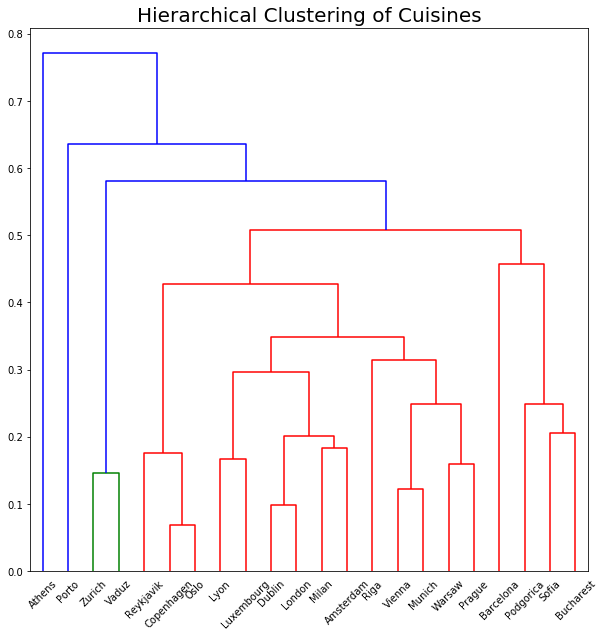

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

q = 0.5

X = df_cuisine_vectors

# Normaize features
X = normalize(X)

X = X**q

X = normalize(X)

# generate the linkage matrix
# method = single (min), complete (max), average, centroid, median, ward
# metric: ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#         ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, 
#         ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, 
#         ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’
linked = linkage(X, method='complete', metric='cosine')

fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.set_title('Hierarchical Clustering of Cuisines', fontsize=20)
#ax.set_title('Hierarchical Clustering Dendrogram')
#ax.set_xlabel('distance')
#ax.set_ylabel('name')
dendrogram(linked,
            orientation='top',
            labels=city_list,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [138]:
from sklearn.cluster import AgglomerativeClustering 

num_clusters = 10
hc = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'cosine', linkage ='complete')
hc.fit(X)
labels = hc.labels_

In [139]:
city_coords = [(53.3498,-6.2603),(47.3769,8.5417),(52.2297,21.0122),(48.2082,16.3738),
               (56.9496,24.1052),(50.0755,14.4378),(42.4304,19.2594),(37.9838,23.7275),
               (41.1579,-8.6291),(41.3851,2.1734),(45.4642,9.1900),(55.6761,12.5683),
               (64.1466,-21.9426),(45.7640,4.8357),(48.1351,11.5820),(49.6116,6.1319),
               (59.9139,10.7522),(47.1410,9.5209),(42.6977,23.3219),(52.3676,4.9041),
               (44.4268,26.1025),(51.5074,-0.1278)]

colors = ['red','blue','green','orange','#cc31ad','#3186cc','#edf728','#8cf536','darkred','#716987']
#colors = ['red','blue','green','orange','#cc31ad']


In [140]:
# Coordinates of Central Europe
#latitude = 49.503551
#longitude = 9.5407
latitude = 49.503551
longitude = 9.5407

# create map of Toronto using latitude and longitude values
map_europe = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for i in range(len(city_list)):
    lat = city_coords[i][0]
    lng = city_coords[i][1]
    label = '{}'.format(city_list[i])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color=colors[labels[i]],
        fill=True,
        fill_color=colors[labels[i]],
        fill_opacity=1,
        parse_html=False).add_to(map_europe)  

map_europe.fit_bounds([[60.96, 0], [37, 29]])
    
map_europe

In [84]:
for j in range(num_clusters):
    
    bool_list = (labels==j)

    cities = []
    for i in range(len(labels)):
        if bool_list[i] == True:
            cities.append(city_list[i])
        
    print(cities)

['Podgorica', 'Sofia', 'Bucharest']
['Warsaw', 'Vienna', 'Prague', 'Munich']
['Copenhagen', 'Reykjavik', 'Oslo']
['Dublin', 'Milan', 'Amsterdam', 'London']
['Lyon', 'Luxembourg']
['Porto']
['Barcelona']
['Athens']
['Riga']
['Zurich', 'Vaduz']


# Demographics

In [146]:
country_list = ['Ireland','Switzerland','Poland','Austria','Latvia','Czechia','Montenegro',
                'Greece','Portugal','Spain','Italy','Denmark','Iceland','France','Germany',
                'Luxembourg','Norway','Liechtenstein','Bulgaria','Netherlands','Romania','UK']


def get_citizenship_filename(country):
    
    if country == 'France':
        filename = 'France_2017.csv'
    elif country == 'Montenegro':
        filename = 'Montenegro_2011.csv'
    else:
        filename = '{}_2019.csv'.format(country)
    
    return('./Data/Citizenship/{}'.format(filename))
    
    
' Read and process population data ' 
df_demo = pd.DataFrame()
for country in country_list:
    
    file_location = get_citizenship_filename(country)
    df_country = pd.read_csv(file_location)
    
    ' Transform dataframe '
    df_country = df_country[ df_country['SEX']=='Total' ]
    df_country = df_country[['GEO','CITIZEN','Value']]
    df_country.rename(columns={"GEO": "country", "CITIZEN": "citizenship","Value":"count"}, inplace=True)
    df_country.drop(df_country.index[df_country['citizenship'] == 'Total'], inplace = True)
    df_country['count'] = df_country['count'].str.replace(",", "").replace(":", "0")
    df_country['count'] = df_country['count'].astype('int32')
    country_name = df_country['country'].unique()[0].split()[0].lower()
    df_country.drop('country', axis=1, inplace=True)
    df_country.set_index('citizenship', inplace=True)
    df_country.columns = [country_name]
    
    ' Join to master dataframe '
    df_demo = df_country.join(df_demo)
    
    
' Rename United Kingdom -> UK '
df_demo.rename(columns={'united':'uk'},inplace=True)


In [147]:
df_demo.head(3)

,uk,romania,netherlands,bulgaria,liechtenstein,norway,luxembourg,germany,france,iceland,...,spain,portugal,greece,montenegro,czechia,latvia,austria,poland,switzerland,ireland
citizenship,,,,,,,,,,,,,,,,,,,,,
Belgium,23135,985,34447,209,25,1284,19953,25904,102066,104,...,36980,4147,1279,1,809,37,2575,660,13474,1674
Bulgaria,102345,2814,31208,6896086,11,7349,1726,319271,23188,414,...,123335,6931,81174,32,15632,115,29920,2327,10054,2592
Czechia,46573,543,4144,416,22,1898,1130,56259,4628,692,...,0,463,913,23,10092342,34,13590,1123,8407,5302


In [144]:
def get_entropy(p):
    """ Takes in pandas series and returns the Shannon entropy """
    
    ' Calculate Shannon entropy '
    entropy = ( -1.0*p*np.log(p) ).sum()
    
    return entropy


def get_renyi_entropy(p,q):
    
    ' Calculate entropy '
    if q == 1:
        entropy = ( -1.0*p*np.log(p) ).sum()
    else:
        entropy = -1.0*( 1.0/float(q-1) )*np.log( (p**q).sum() )
    
    return entropy


def get_frequency(values, exclude_zeros=True):
    """ Takes in a pandas Series and returns normalised values """
    
    total = float( values.sum() )
    
    freq = values/float(total)
    
    if exclude_zeros == True:
        freq = freq[ freq>0 ]
    
    return freq

In [148]:
pop_entropy = []

for country in country_list:
    
    sCounts = df_demo[ country.lower() ]
    
    sFrequency = get_frequency(sCounts)
    
    pop_entropy.append( get_entropy(sFrequency) )


In [172]:
labels1 = labels + 1
df = pd.DataFrame({'country':country_list,'cluster_id':labels1,'diversity':pop_entropy})
df = df[['country','cluster_id','diversity']]
df.head()

,country,cluster_id,diversity
0,Ireland,4,0.769847
1,Switzerland,10,1.348761
2,Poland,2,0.009112
3,Austria,2,0.979421
4,Latvia,9,0.207861


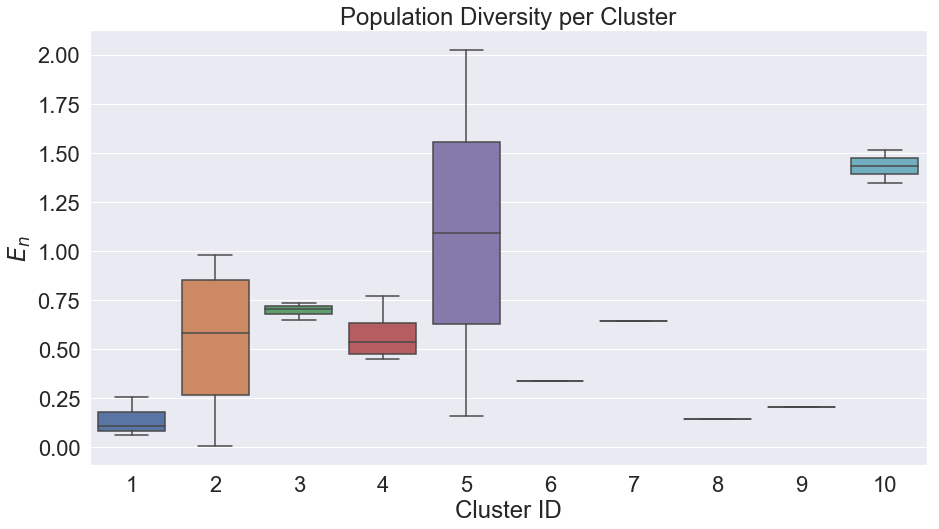

In [175]:
import seaborn as sns
#sns.relplot(x="cluster_id", y="diversity", hue="cluster_id", data=df);
plt.figure(figsize=(15,8))
sns.set(font_scale=2)
ax = sns.boxplot( x=df["cluster_id"], y=df["diversity"] );
ax.set_title('Population Diversity per Cluster');
ax.set_xlabel('Cluster ID');
ax.set_ylabel('$E_n$');
#ax.annotate("hello",(1,1))
#legend = ["UV Weak", "UV Upturn"]
#plt.legend(legend)
ax.get_figure().savefig('BoxPlot.png')

In [186]:
df[df['cluster_id']==10]

,country,cluster_id,diversity
1,Switzerland,10,1.348761
17,Liechtenstein,10,1.513336


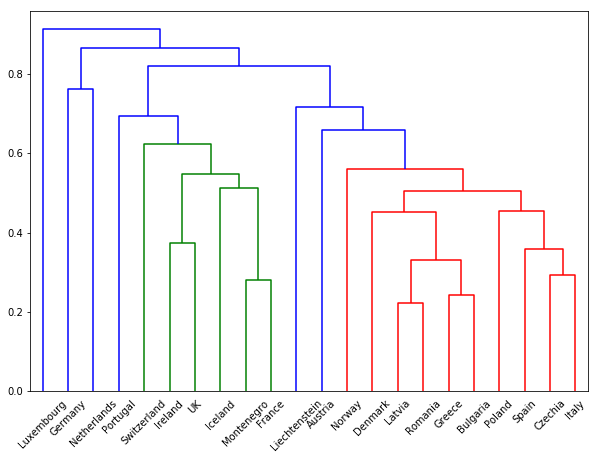

In [190]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

q = 0.3

X = df_demo

# Normaize features
X = normalize(X)

X = X**q

X = normalize(X)

# generate the linkage matrix
# method = single (min), complete (max), average, centroid, median, ward
# metric: ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#         ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, 
#         ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, 
#         ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’
linked = linkage(X, method='complete', metric='cosine')

labelList = range(len(X))

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=country_list,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

## CONCLUSION

**Strong Similarity**

France & Montenegro !?

Greece, Latvia, Romania, Bulgaria


**Medium Similarity**

UK & Ireland

Denmark & Switzerland

** Outliers **

Luxembourg - Very different demographics to rest of Europe - Last to be clustered
